# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [82]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [83]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [84]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [214]:
# DataFrame transformation/manipulation

file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")



house_units = sfo_data.groupby('year').mean()
min = house_units.min()['housing_units']
max = house_units.max()['housing_units']

sfo_data.groupby(by='year')['sale_price_sqr_foot', 'gross_rent'].mean()



# Define Panel Visualization Functions

def housing_units_per_year():
    """Housing Units Per Year."""
    housing_units_peryrfig = plt.figure() 
    house_units.plot.bar(ylim =(min-2000, max+2000),title="Housing Units in San Francisco from 2010-2016", figsize=(12,8))
    plt.close(housing_units_peryrfig)
    return pn.pane.Matplotlib(housing_units_peryrfig)

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    average_gross_rentfig = plt.figure()
    avg_gross_rent = sfo_data.groupby(by='year')['gross_rent'].mean().plot(y='Average Gross Rent', title= "Average Gross Rent in San Francisco",figsize=(12,8), color='aqua')
    plt.close(average_gross_rentfig)
    return pn.pane.Matplotlib(average_gross_rentfig)

def average_sales_price():
    """Average Sales Price Per Year."""
    average_sales_pricefig = plt.figure()    
    avg_sqft= sfo_data.groupby(by='year')['sale_price_sqr_foot'].mean().plot(y='Average Sale Price',title="Average Price per SqFt by Year",figsize=(12,8), color='yellow')
    plt.close(average_sales_pricefig)
    return pn.pane.Matplotlib(average_sales_pricefig)

def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    neighborhood_mean = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean()
    neighborhood_mean.reset_index(inplace=True)
    
    neighborhood_mean= neighborhood_mean.hvplot.line(
    x="year",
    y="sale_price_sqr_foot",
    xlabel= "Year",
    ylabel="Average Price per SqFt by Year",
    groupby="neighborhood",
    )   
        
    return (neighborhood_mean)

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""

    ten_most_expensive_neighborhoods = sfo_data.groupby("neighborhood").mean()
    ten_most_expensive_neighborhoods = ten_most_expensive_neighborhoods.sort_values("sale_price_sqr_foot", ascending=False).head(10)
    ten_most_expensive_neighborhoods = ten_most_expensive_neighborhoods.reset_index()

    ten_most_expensive_neighborhoods= ten_most_expensive_neighborhoods.hvplot.bar(
    x="neighborhood",
    y="sale_price_sqr_foot",
    title="Top 10 Most Expensive Neighborhoods",
    xlabel="Neighborhood",
    ylabel="Average Price per SqFt",
    height=500,
    color="pink",
    rot=45
    )

    return (ten_most_expensive_neighborhoods)

def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    
    most_expensive_neighborhoods = sfo_data.groupby("neighborhood").mean()
    most_expensive_neighborhoods = most_expensive_neighborhoods.reset_index()


    most_expensive_neighborhoods= most_expensive_neighborhoods.hvplot.bar(
    x="neighborhood",
    y=["gross_rent","sale_price_sqr_foot"],
    title="Most Expensive Neighborhoods",
    xlabel="Neighborhood",
    ylabel="Number of Houses",
    groupby= "neighborhood",
    height=500,
    color="pink",
    rot=45
    )

    return (most_expensive_neighborhoods)

    
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    neighborhood_mean = sfo_data.groupby(by= "neighborhood").mean()
    neighborhood_mean = neighborhood_mean.sort_values("sale_price_sqr_foot", ascending=False).head(10)
    neighborhood_mean.reset_index(inplace=True)
    df_expensive_neighborhoods=px.parallel_coordinates(
    neighborhood_mean,
    title= "Parallel Coordinates Analysis",
    color='sale_price_sqr_foot')
    return (df_expensive_neighborhoods)


def parallel_categories():
    """Parallel Categories Plot."""
    
    ten_most_expensive_neighborhoods = sfo_data.groupby("neighborhood").mean()
    ten_most_expensive_neighborhoods = ten_most_expensive_neighborhoods.sort_values("sale_price_sqr_foot", ascending=False).head(10)
    ten_most_expensive_neighborhoods = ten_most_expensive_neighborhoods.reset_index()
    neighborhood_mean = sfo_data.groupby(by= "neighborhood").mean()
    neighborhood_mean = neighborhood_mean.sort_values("sale_price_sqr_foot", ascending=False).head(10)
    neighborhood_mean.reset_index(inplace=True)
    df_expensive_neighborhoods_per_year = neighborhood_mean[neighborhood_mean ["neighborhood"].isin(ten_most_expensive_neighborhoods["neighborhood"])]
    df_expensive_per_year= px.parallel_categories(
    df_expensive_neighborhoods_per_year,
    dimensions=['neighborhood','sale_price_sqr_foot', 'housing_units', 'gross_rent'],
    title= "Parallel Categories Analysis",
    color="sale_price_sqr_foot"
    )

    return (df_expensive_per_year)
    
def neighborhood_map():
    """Neighborhood Map."""
    px.set_mapbox_access_token(map_box_api)
    file_path = Path("Data/neighborhoods_coordinates.csv")
    neighborhood_locations = pd.read_csv(file_path)
    neighborhood_mean = sfo_data.groupby(by= "neighborhood").mean()
    neighborhood_mean.reset_index(inplace=True)
    neighborhood_mean.rename(columns={"neighborhood": "Neighborhood"}, inplace=True)
    neighborhood_mean
    df_all_neighborhoods = pd.merge(
        df_neighborhood_locations, neighborhood_mean, on="Neighborhood"
    )
    neighborhood_map = px.scatter_mapbox(
        df_all_neighborhoods,
        lat="Lat",
        lon="Lon",
        size="sale_price_sqr_foot",
        color="gross_rent",
        color_continuous_scale=px.colors.cyclical.IceFire,
        size_max=15,
        zoom=11,
        hover_name="Neighborhood",
        title="Average Sale Price Per Square Foot and Gross Rent in San Francisco",
    )
    plotly_panel = pn.pane.Plotly(neighborhood_map)
    plotly_panel._updates = True
    return plotly_panel

def sunburst():
    """Sunburst Plot."""
    sfo_data.reset_index(inplace=True)
    ten_most_expensive_neighborhoods = sfo_data.groupby("neighborhood").mean()
    ten_most_expensive_neighborhoods = ten_most_expensive_neighborhoods.sort_values("sale_price_sqr_foot", ascending=False).head(10)
    ten_most_expensive_neighborhoods = ten_most_expensive_neighborhoods.reset_index()
    neighborhood_mean = sfo_data.groupby(by= "neighborhood").mean()
    neighborhood_mean = neighborhood_mean.sort_values("sale_price_sqr_foot", ascending=False).head(10)
    neighborhood_mean.reset_index(inplace=True)
    neighborhood_mean.rename(columns={"Neighborhood": "neighborhood"}, inplace=True)
    print (neighborhood_mean.columns)
    print (ten_most_expensive_neighborhoods.columns)
    df_expensive_neighborhoods_per_year = neighborhood_mean[neighborhood_mean["neighborhood"].isin(ten_most_expensive_neighborhoods["neighborhood"])]
    sunburst = px.sunburst(df_expensive_neighborhoods_per_year, path=['year', 'neighborhood'],
                  color='gross_rent',
                  color_continuous_scale='rdbu',
                  color_continuous_midpoint=np.average(df_expensive_neighborhoods_per_year['gross_rent']))
    return (sunburst)

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

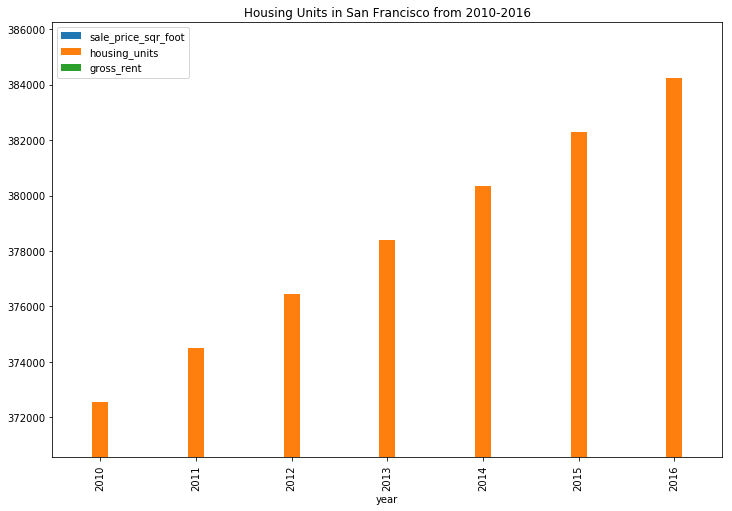

In [179]:
# Create a Title for the Dashboard
title = pn.pane.Markdown(
    """
    # San Francisco Housing Cost Analysis
    """,
    width=500,
)


welcome = pn.pane.Markdown(
    """
    This dashboard displays visual analysis of historical sales and pricing data from 2010 to 2016 in the San Francisco market. 
    These graphs will help you assess the changes that have been made in the San Francisco market To gain an insight on the trends. 
    """
)

# Create a tab layout for the dashboard

tabs = pn.Tabs(
    ("Welcome", pn.Column(welcome, neighborhood_map())),
    ("Yearly Real Estate Market Analysis", pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())),
    ("Neighborhood Analysis", pn.Column(average_price_by_neighborhood(), top_most_expensive_neighborhoods())),
    ("Parallel Plots", pn.Column(parallel_coordinates(), parallel_categories(), width=960),)
)


# Create the dashboard

panel = pn.Column(pn.Row(title), tabs, width=500)

## Serve the Panel Dashboard

Column(width=500)
    [0] Row
        [0] Markdown(str, width=500)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
        [1] Row
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
        [2] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
            [1] HoloViews(Bars)
        [3] Column(width=960)
            [0] Plotly(Figure)
            [1] Plotly(Figure)
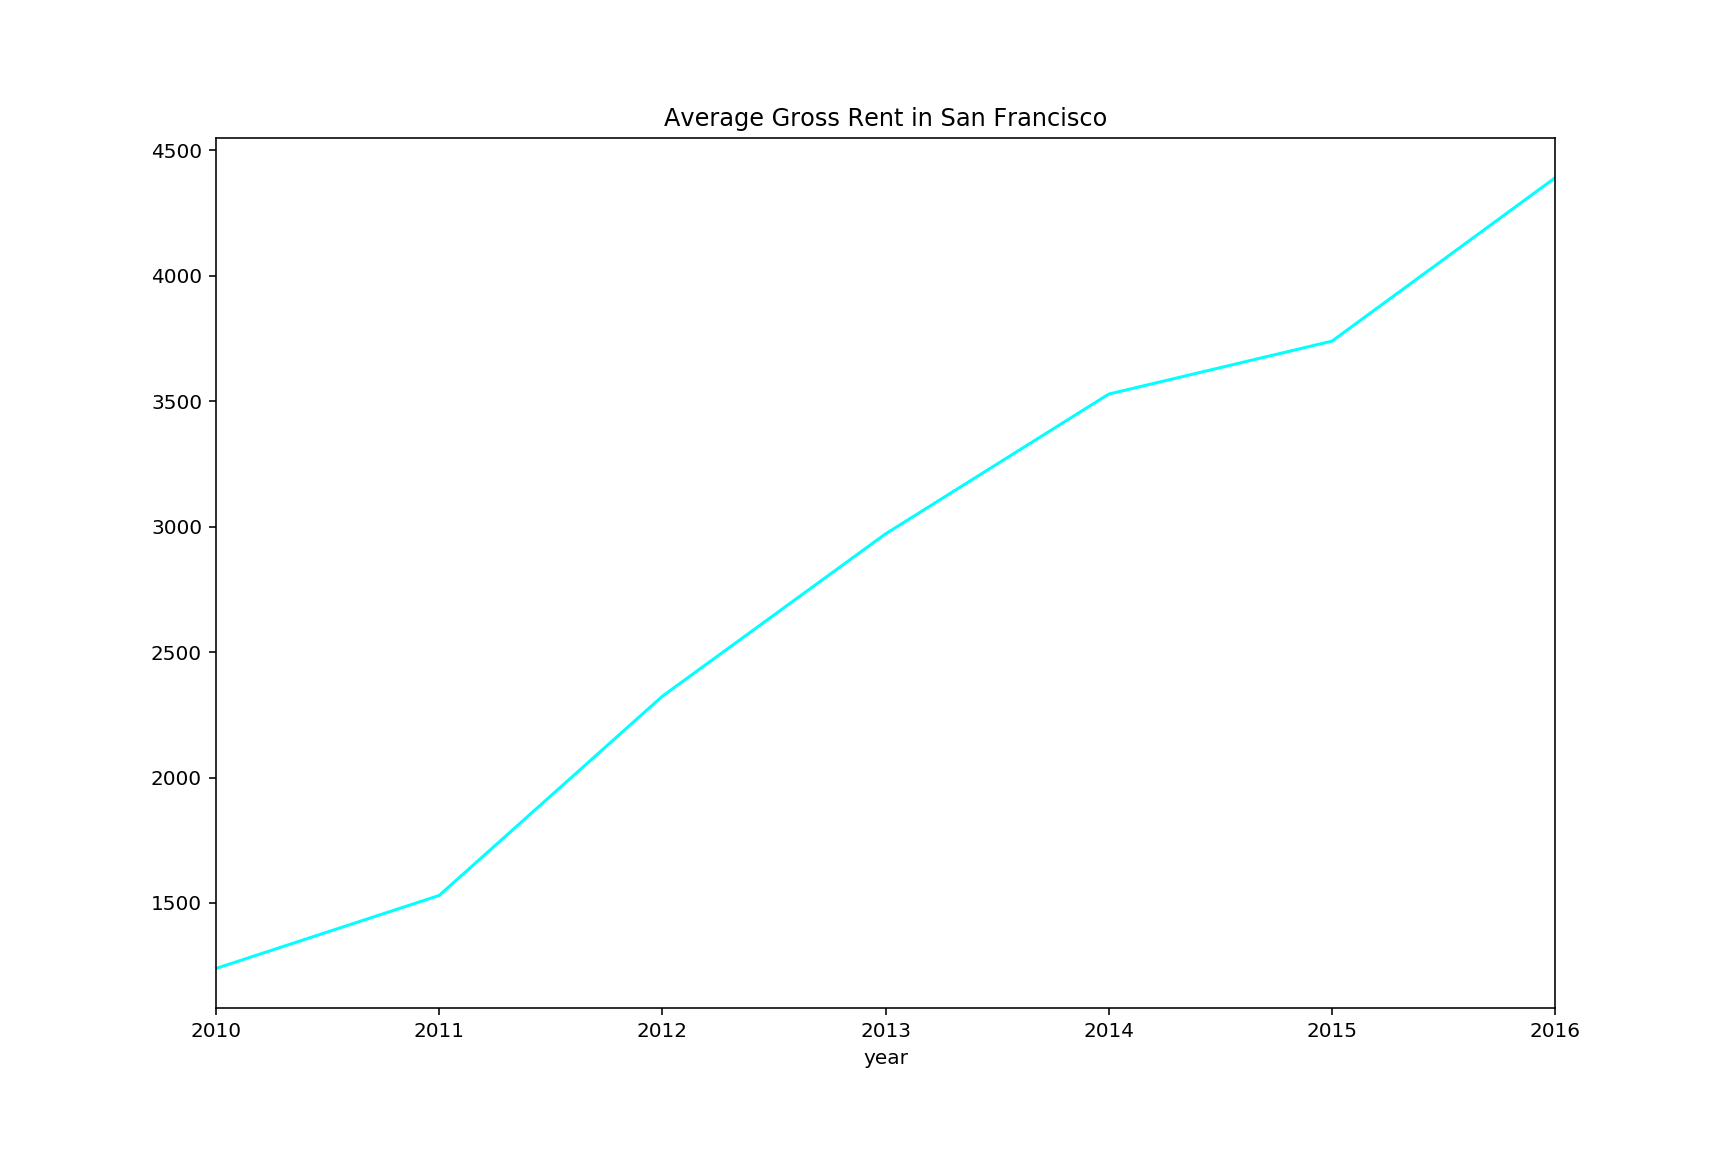
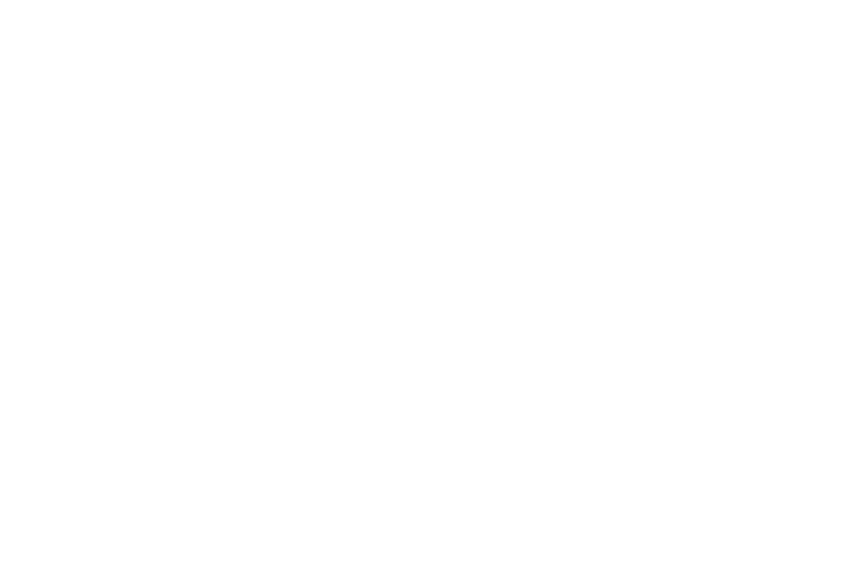
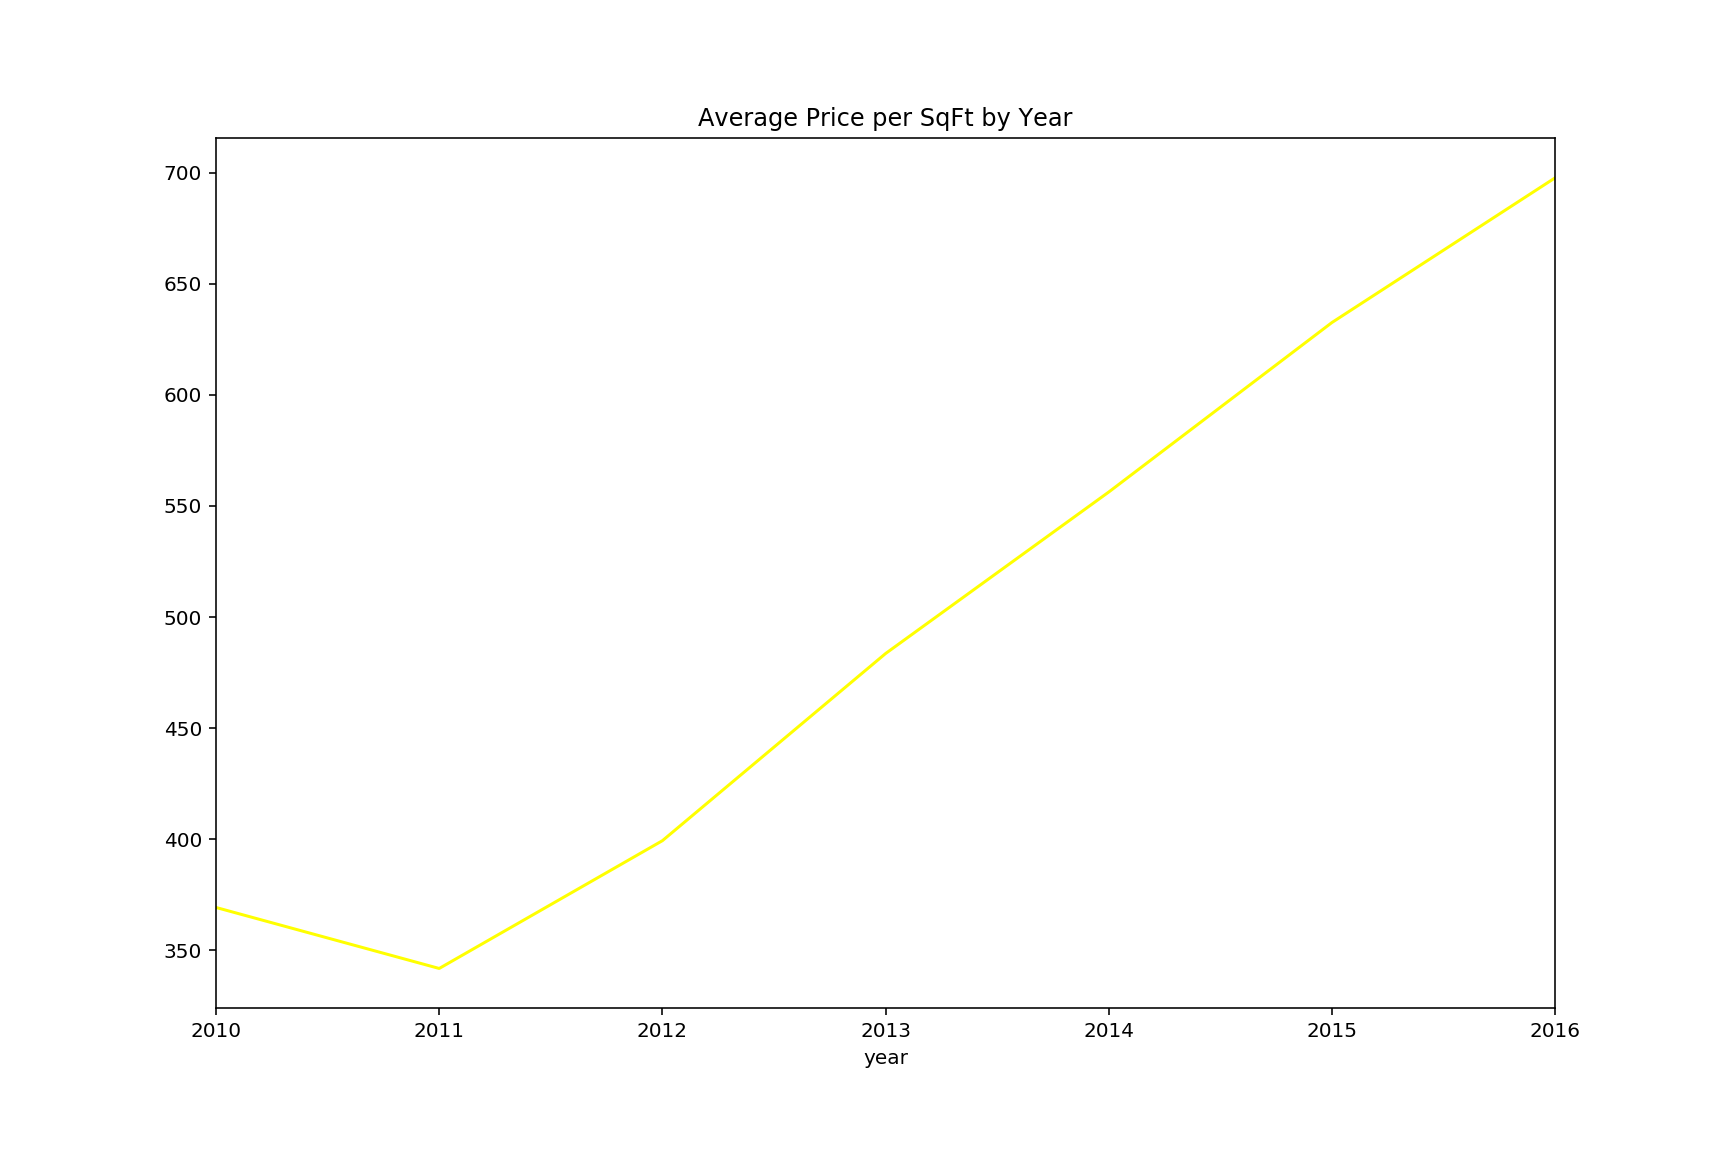

In [180]:
# Serve the# dashboard
panel.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

Matplotlib(Figure)
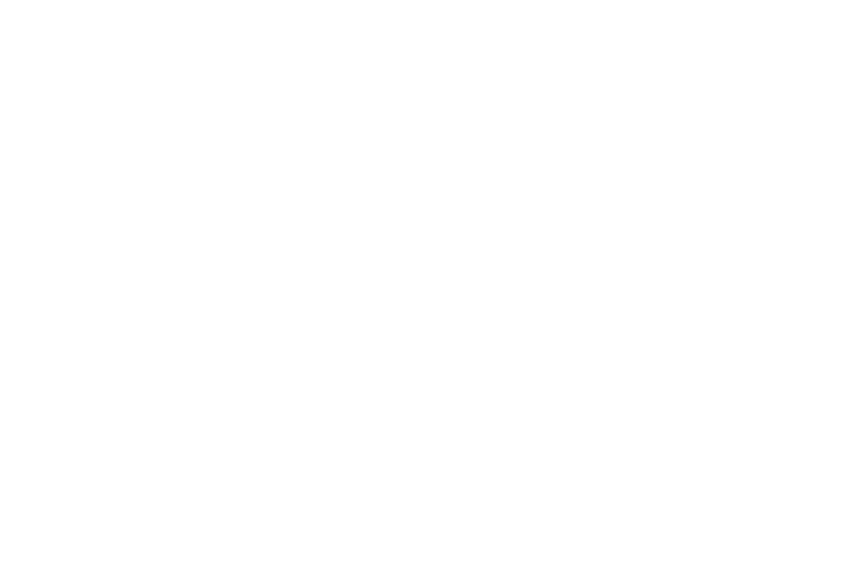

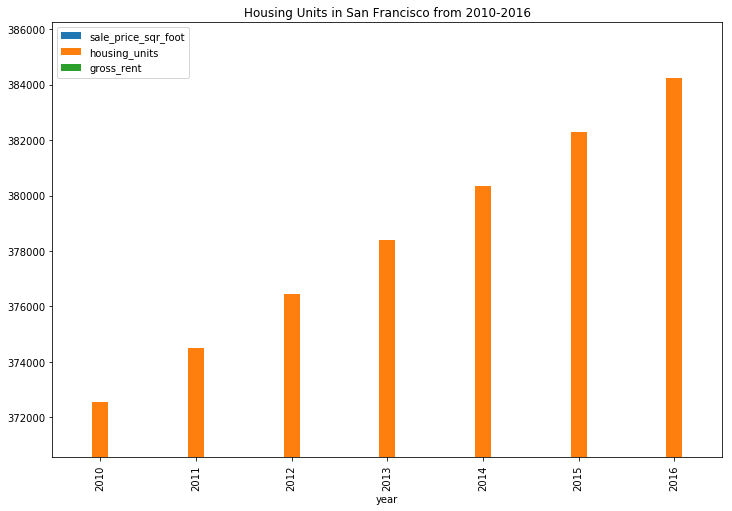

In [137]:
housing_units_per_year()

Matplotlib(Figure)
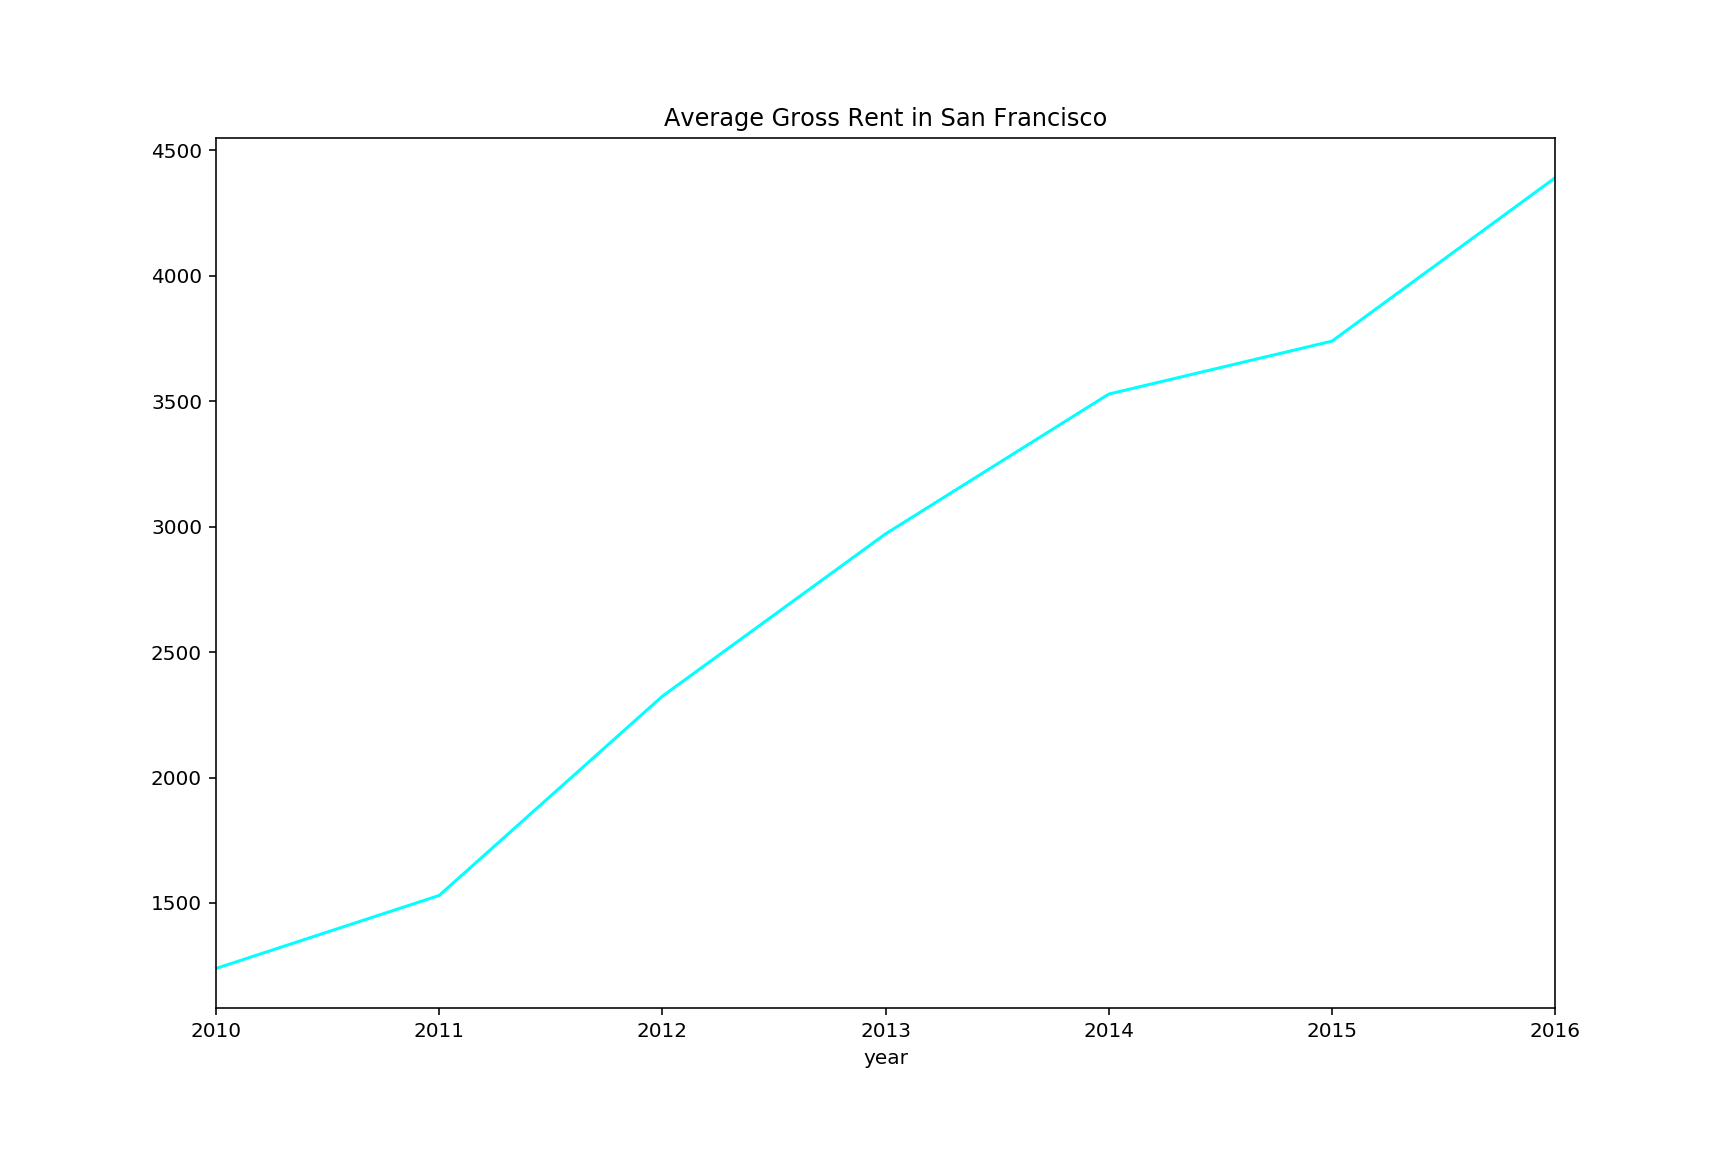

In [138]:
average_gross_rent()

Matplotlib(Figure)
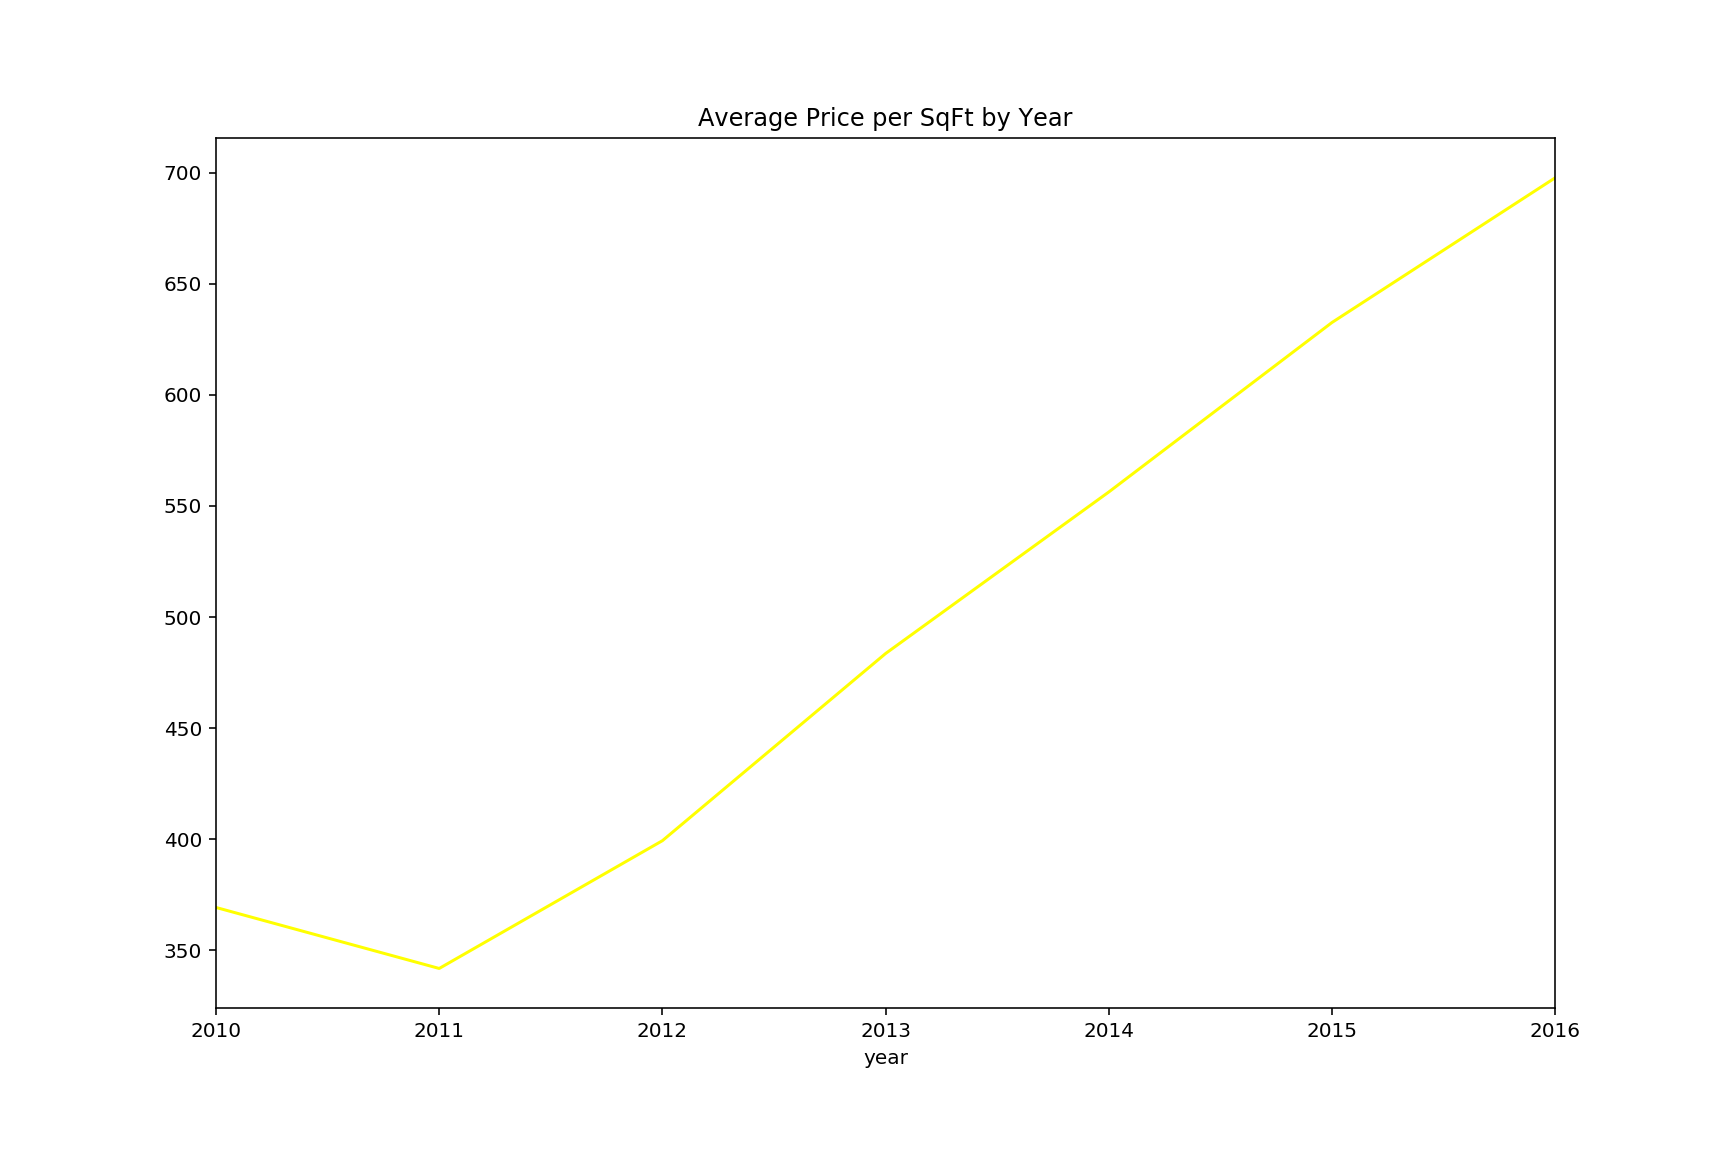

In [139]:
average_sales_price()

In [140]:
average_price_by_neighborhood()

:DynamicMap   [neighborhood]
   :Curve   [year]   (sale_price_sqr_foot)

In [141]:
top_most_expensive_neighborhoods()

:Bars   [neighborhood]   (sale_price_sqr_foot)

In [142]:
most_expensive_neighborhoods_rent_sales()

:DynamicMap   [neighborhood]
   :Bars   [neighborhood,Variable]   (value)

In [143]:
neighborhood_map().show()

Launching server at http://localhost:53374


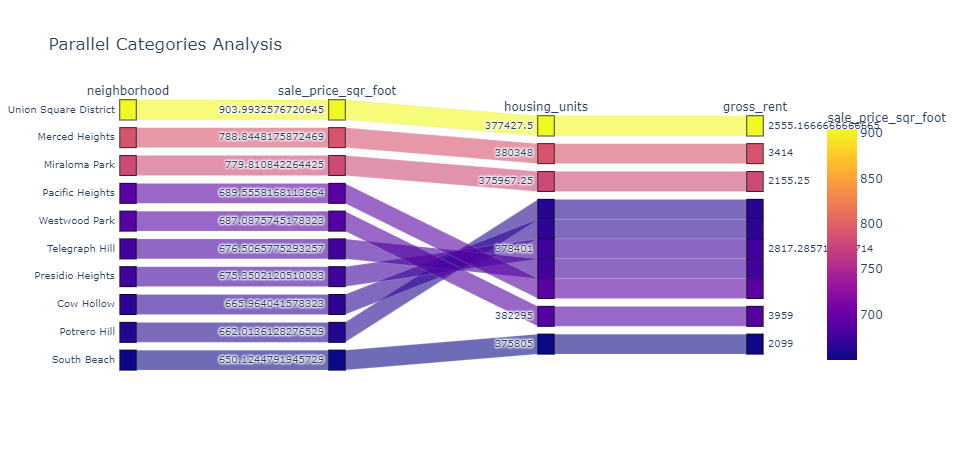

In [173]:
parallel_categories()

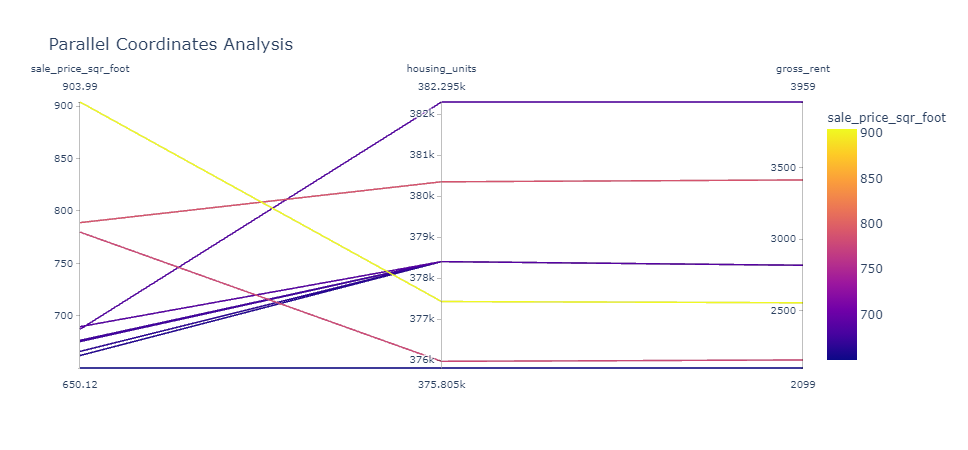

In [145]:
parallel_coordinates()

Index(['neighborhood', 'year', 'sale_price_sqr_foot', 'housing_units',
       'gross_rent'],
      dtype='object')
Index(['neighborhood', 'year', 'sale_price_sqr_foot', 'housing_units',
       'gross_rent'],
      dtype='object')


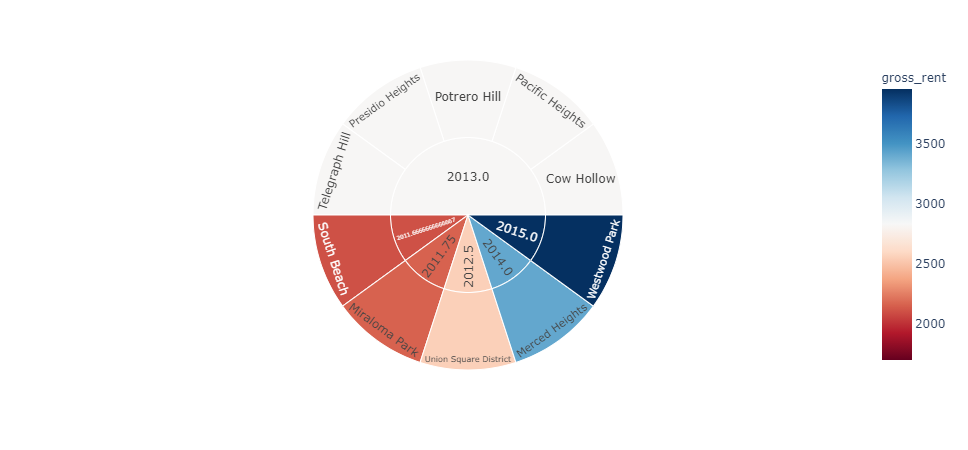

In [215]:
sunburst()